In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from statsmodels.tsa.stattools import acf
from scipy.stats import lognorm
from scipy.optimize import curve_fit
from tensorflow.keras.models import load_model
import tensorflow as tf

# Lorentzian model
def lorentzian(f, A, f0, gamma):
    return A / (1 + ((f - f0) / gamma) ** 2)

# QPO quality factor from PSD
def compute_qpo_q(series, fs=1, f_window=(0.01, 0.5)):
    f, Pxx = welch(series.squeeze(), fs=fs, nperseg=256)
    mask = (f > f_window[0]) & (f < f_window[1])
    f_fit = f[mask]
    P_fit = Pxx[mask]
    try:
        p0 = [np.max(P_fit), f_fit[np.argmax(P_fit)], 0.01]
        popt, _ = curve_fit(lorentzian, f_fit, P_fit, p0=p0)
        A, f0, gamma = popt
        if gamma > 0 and f0 > 0:
            return f0 / gamma, f0
    except:
        pass
    return 0.0, None

# PNR (Peak-to-noise ratio)
def peak_to_noise_ratio(series):
    f, Pxx = welch(series.squeeze(), fs=1, nperseg=256)
    return np.max(Pxx) / np.median(Pxx)

# Main diagnostic plotter
def plot_gan_diagnostics(series, fs=1, title_prefix="GAN", show=True):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # Light curve
    axes[0].plot(series, lw=1)
    axes[0].set_title("Generated Light Curve")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Flux")

    # PSD + QPO peak
    f, Pxx = welch(series.squeeze(), fs=fs, nperseg=256)
    q_val, f_qpo = compute_qpo_q(series)
    axes[1].semilogy(f, Pxx)
    if f_qpo:
        axes[1].axvline(f_qpo, color='red', linestyle='--', label=f"QPO fc = {f_qpo:.2f} Hz\nQ = {q_val:.2f}")
    axes[1].set_title("Power Spectral Density")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Power")
    axes[1].legend()

    # ACF
    autocorr = acf(series.squeeze(), nlags=100, fft=True)
    axes[2].plot(autocorr)
    axes[2].set_title("Autocorrelation (ACF)")
    axes[2].set_xlabel("Lag")
    axes[2].set_ylabel("Correlation")

    # Histogram + lognorm fit
    shape, loc, scale = lognorm.fit(series - np.min(series) + 1e-6)
    x = np.linspace(np.min(series), np.max(series), 100)
    pdf = lognorm.pdf(x, shape, loc, scale)

    axes[3].hist(series, bins=40, density=True, alpha=0.6, label="Flux")
    axes[3].plot(x, pdf, '--', label="LogNorm Fit")
    axes[3].set_title("Flux Histogram")
    axes[3].legend()

    # Main title
    pnr = peak_to_noise_ratio(series)
    full_title = f"{title_prefix} | Q = {q_val:.2f} | PNR = {pnr:.2f}"
    fig.suptitle(full_title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if show:
        plt.show()

    return q_val, pnr


In [8]:
# ✅ Load Trained Generator
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

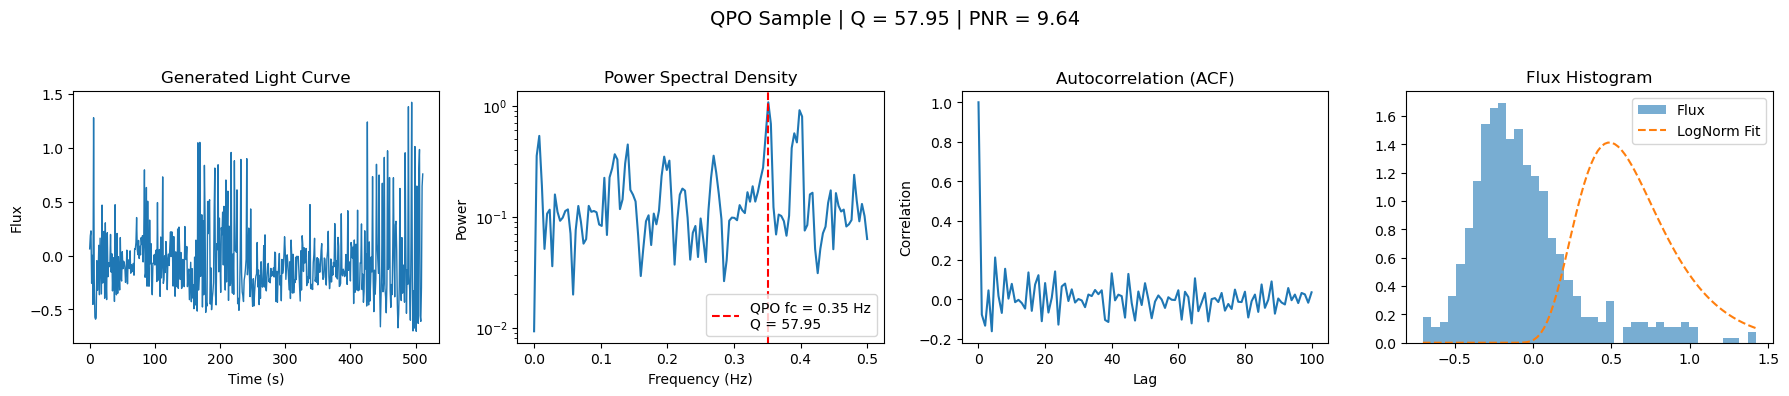

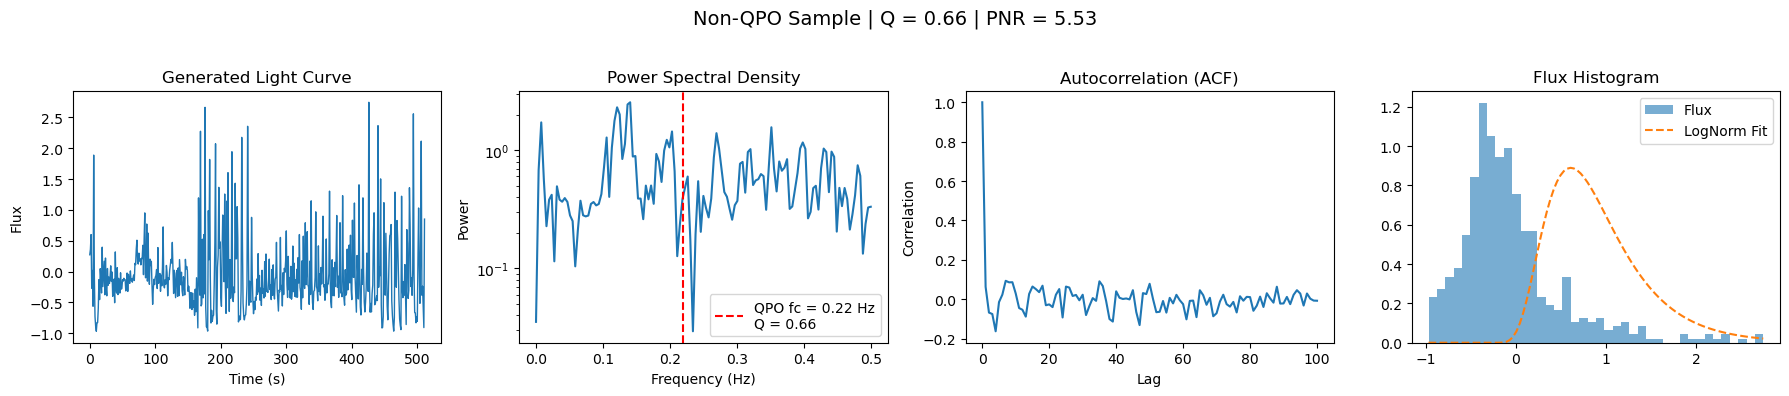

(0.6563835675855927, 5.532647)

In [9]:
# Example: Visualizing one QPO and one non-QPO sample
z = tf.random.normal((1, 100))
label_qpo = tf.convert_to_tensor([[0.25, 0.8, 1.0]], dtype=tf.float32)
label_noqpo = tf.convert_to_tensor([[0.25, 0.8, 0.0]], dtype=tf.float32)

qpo_signal = generator([z, label_qpo], training=False).numpy().squeeze()
noqpo_signal = generator([z, label_noqpo], training=False).numpy().squeeze()

# Visualize
plot_gan_diagnostics(qpo_signal, title_prefix="QPO Sample")
plot_gan_diagnostics(noqpo_signal, title_prefix="Non-QPO Sample")
